# Localización de objetos



**Objetivo**: Aprender a localizar objetos mediante su color en imágenes simples.

**Conocimientos previos**: Conceptos básicos de imágenes digitales color y escala de grises. Programación en Python con la librería Numpy. Lectura, visualización y manipulación de imágenes con Numpy, PyPlot y skimage.

**Importante**: Para que este cuaderno funcione correctamente, las imágenes 'guante.png' y 'guante_zoom.png' deben estar en el mismo directorio que este cuaderno.

En este tutorial veremos una forma sencilla de localizar un objeto en una imagen. Para eso, vamos a realizar dos asunciones sobre el objeto:
* Tiene un color relativamente uniforme en toda su superficie
* Es el único objeto con ese color en la imagen. 

En este caso, vamos a intentar encontrar el guante rojo de la persona en la imagen:

![Persona con guantes de color](guante.png "Persona con guantes de color")

Nuestro objetivo entonces es obtener las coordenadas $(x,y)$ del guante.

La idea principal del método es encontar los píxeles que tengan el color del guante.

Algunos pixeles que no son del guante también serán encontrados; llamaremos a estos pixeles *ruido*. Luego, eliminaremos el ruido.

Por último, podemos encontrar el centro de la zona contigua que tiene ese color, o sea, del guante.

Comenzaremos cargando varias librerías que luego nos serán útiles. Luego cargaremos la imagen y veremos las distintas operaciones necesarias para encontrar el objeto.

In [1]:

# comando de Jupyter para que las imagenes se muestren automaticamente 
%matplotlib inline

#numpy es la libreria de arreglos de python (la llamaremos np)
import numpy as np

# el modulo pyplot de matplotlib (que llamaremos plt) nos permite mostrar imagenes
import matplotlib.pyplot as plt
#el modulo matplotlib.colors nos permite transformar el espacio de color de una imagen
import matplotlib.colors
# el mapa de color para las imágenes escala de grises es el gris 
plt.rcParams['image.cmap'] = 'gray'


#el modulo io de skimage sirve para cargar y guardar imagenes
from skimage import io


Luego, cargamos la imagen y la mostramos para verificar que se cargó correctamente.

Dimensiones de la imagen: (480, 640, 3)
Tipo de los elementos de la imagen: float64


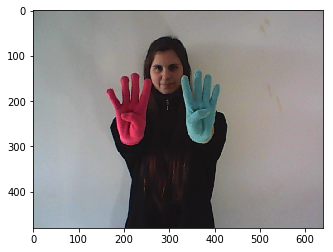

In [2]:

# leemos la imagen desde un archivo, y la almacenamos en memoria en un arreglo
image = io.imread('guante.png')

# Convertimos la imagen de entero a flotante, y además convertimos el rango de los pixeles
# de 0-255 (entero) al rango 0-1 (flotante)
image=image/255.

#imprimimos las tres dimensiones del arreglo: las dos primeras corresponden al alto y ancho, 
#la última a los canales de color (3 canales, por defecto RGB)
print("Dimensiones de la imagen: %s" % str(image.shape))

#guardamos las dimensiones en tres variables para usar en las celdas más abajo
h,w,c=image.shape

#mostramos el tipo de los elementos del arreglo (debería ser flotante!)
print("Tipo de los elementos de la imagen: %s" % str(image.dtype))

#visualizamos la imagen
plt.imshow(image)


## Filtrado por color

Una manera simple de reconocer un objeto es mediante su color. Si ese color es muy distintivo y uniforme (las asunciones que mencionamos arriba), podemos recorrer la imagen para encontrar los pixeles de ese color.


Enfoquémosnos en la remera:

![Guante de color](guante_zoom.png "Guante de color")

Como se puede ver no hay _un_ solo rojo sino varios, por variaciones de la iluminación y la textura de la remera.

Entonces, en lugar de buscar _un_ color en particular, vamos a tener que buscar un rango de colores. Pero esto va a resultar difícil con el espacio de color RGB.


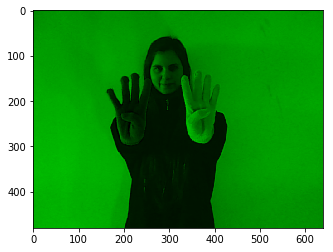

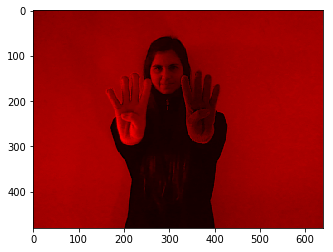

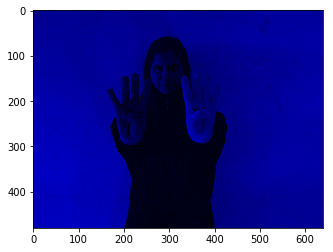

In [3]:
#Vemos los canales individuales de RGB. 
#El fondo blanco activa los 4 canales (R,G y B)
# El buzo y el pelo, al ser negro oscuro, no se activan en ningún canal
# Por otro lado, el guante rojo se activa en el canal rojo y no en los otros dos
# Y el guante celeste se activa en los canales verde (mayormente) y azul

#Anulo los canales rojo y azul para ver solo el verde
green=np.copy(image)
green[:,:,0]=0
green[:,:,2]=0
plt.figure()
plt.imshow(green)

#Anulo los canales azul y verde para ver solo el rojo
red=np.copy(image)
red[:,:,1:3]=0
plt.figure()
plt.imshow(red)

#Anulo los canales rojo y verde para ver solo el azul
blue=np.copy(image)
blue[:,:,0:2]=0
plt.figure()
plt.imshow(blue)


## Conversión al espacio de colores HSV

En lugar de eso vamos a convertir los píxeles desde el espacio RGB al espacio HSV, en donde cada píxel se codifica también con tres valores, pero ahora con significado diferente:

 * El canal H indica el tono (hue) del color (verde, rojo, azul, amarillo, etc).
   * El tono es lo que tradicionalmente entendemos como "color".
 * El canal S indica la saturación (saturation) de color
   * Si un color es más saturado, es más "puro"
   * Si es menos saturado, tiene más "gris"
 * El canal V indica la luminosidad o intensidad (value) del pixel. 
   * V=0 indica un pixel negro
   * V=1 indica un pixel blanco
   
TODO poner ejemplos de colores HSV

La función `rgb_to_hsv` del módulo `matplotlib.colors`nos permite hacer justamente eso.   

In [4]:
# Convertir en escala de grises
image_hsv=matplotlib.colors.rgb_to_hsv(image)

print("El pixel de la posición (100,100) se codifica en RGB como %s " % str(image[100,100,:]))
print("El pixel de la posición (100,100) se codifica en HSV como %s " % str(image_hsv[100,100,:]))

El pixel de la posición (100,100) se codifica en RGB como [ 0.57647059  0.57647059  0.56862745] 
El pixel de la posición (100,100) se codifica en HSV como [ 0.16666667  0.01360544  0.57647059] 


Ahora miremos los canales HSV por separado

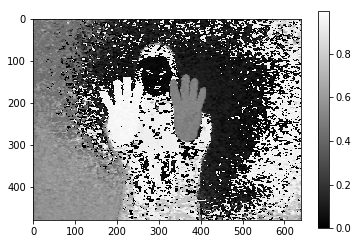

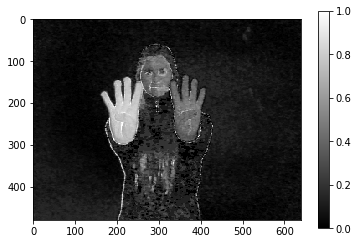

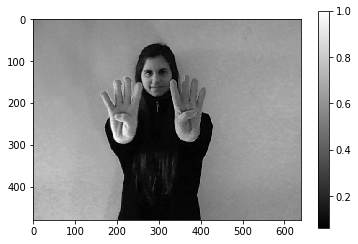

In [5]:
#Vemos los canales individuales de HSV. 

plt.figure()
plt.imshow(image_hsv[:,:,0])
plt.colorbar()

plt.figure()
plt.imshow(image_hsv[:,:,1])
plt.colorbar()

plt.figure()
plt.imshow(image_hsv[:,:,2])
plt.colorbar()


## Filtrando por color


Para filtrar por color, debemos averiguar el rango de colores del guante. Para ello, una forma sencilla consiste en abrir la imagen en un editor de imágenes que permita ver el valor de cada pixel, y anotar los valores de varios pixeles del guante. En este caso lo hicimos con el programa **Pinta** y obtuvimos:
* $(H,S,V)$
* $(347,56,60)$
* $(344,79,47)$
* $(348,77,70)$
* $(347,100,26)$
* $(343,60,86)$
* $(342,77,88)$



Entonces el rango de colores que buscamos es, aproximadamente:

 * H entre $342$ y $347$.
 * S entre $56$ y $100$.
 * V entre $26$ y $88$.
 

Como podemos observar, el canal H es el que mostró menos variación,ya que el tono se mantiene bastante constante. Por otro lado, el S y el V pueden variar mucho de acuerdo a la iluminación.

Para dar un poco más de rango, vamos a expandir un poco estos

* H entre $330$ y $355$.
* S entre $40$ y $100$.
* V entre $20$ y $90$.
 
Por otro lado, el programa **Pinta** así como otros editores de imágenes nos dan estos valores codificados en los rangos 0-360 para H, y 0-100 para V y S, por lo que habría que convertirlos a los intervalos 0-1 que utiliza numpy dividiendo por el extremo del rango, es decir:

 * H entre $342/360$ y $347/360$.
 * S entre $56/100$ y $100/100$.
 * V entre $26/100$ y $88/100$.

In [6]:
#Rango de colores a utilizar

#guante rojo
h_min,h_max=(330/360,355/360)
s_min,s_max=(40/100,100/100)
v_min,v_max=(20/100,90/100)



### Generación de la máscara de segmentación
En base a la imagen original y estos rangos de color, vamos a generar otra imagen llamada la *máscara de segmentación*. Esta máscara es simplemente una imagen en blanco y negro (cada pixel tiene valor $0$ o $1$). Si el pixel $i,j$ de la imagen original está en el rango de color, en la máscara el pixel $i,j$ tendra el valor $1$. Si no, tendra valor $0$.

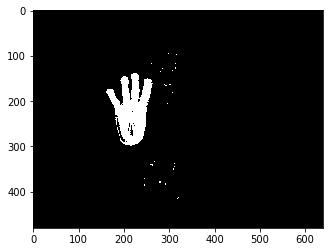

In [7]:
# Filtrar por color para buscar el guante

h,w,c=image_hsv.shape
segmentation_mask=np.zeros((h,w))

for i in range(h):#evitamos los bordes
    for j in range(w): #evitamos los bordes
        h_val,s_val,v_val=image_hsv[i,j,:]
        if h_min<h_val<h_max and s_min<s_val<s_max and v_min<v_val<v_max:
            segmentation_mask[i,j]=1
            
plt.imshow(segmentation_mask,cmap=plt.get_cmap('gray'))            
        


### Filtro de erosión

Como se puede ver en la imagen, han quedado algunos píxeles en blanco aislados donde no está la mano que deberíamos sacar. Estos pixeles suelen llamarse *ruido*. 

Para eso, vamos a implementar una versión simple de un *filtro de erosión* que justamente busca a estos pixeles blancos que tienen vecinos negros. La idea es simplemente, por cada pixel, contar cuántos vecinos en blanco tiene, incluido a si mismo. Si todos son blancos, el pixel se convierte en blanco. Sino, se convierte en negro.

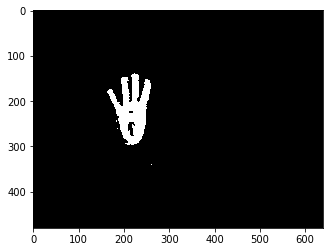

In [8]:
eroded_mask=np.zeros(segmentation_mask.shape) # creamos otra imagen con la misma forma que la mascara de seg.

# erosionar la mascara 
for i in range(1,h-1):#evitamos los bordes
    for j in range(1,w-1): #evitamos los bordes
        #cuenta cuantos pixeles blancos hay en la vecindad del pixel
        pixel_count=(segmentation_mask[i-1,j-1]+segmentation_mask[i-1,j]+segmentation_mask[i-1,j+1] +segmentation_mask[i,j-1]+segmentation_mask[i,j]+segmentation_mask[i,j+1]+segmentation_mask[i+1,j-1]+segmentation_mask[i+1,j]+segmentation_mask[i+1,j+1])
        if pixel_count>8: # si todos son blancos 
            eroded_mask[i,j]=1 # el pixel resultado también es blanco

plt.imshow(eroded_mask,cmap=plt.get_cmap('gray'))            

### Encontrando el centro de la mano

Una forma sencilla de encontrar el centro de la mano es calculando el centro de masa de los pixeles blancos.

El centro de masa es el promedio de las coordenadas de los pixeles blancos (una coordenada es un par $(i,j)$ que me dice la posición del pixel, es decir, su fila y columna).

Por ejemplo, si tengo 3 pixeles blancos con coordenadas $(1,3)$, $(7,5)$, $(4,13)$, el centro de masa es $ \frac{(1,3) + (7,5) + (4,13)}{3}= \frac{(1+7+4,3+5+13)}{3}=\frac{(12,21)}{3}=(4,7)$. 

Entonces lo que debemos hacer es recorrer la imagen, y realizar la suma de las coordenadas de todos los pixeles blancos (valor $1$), y contarlos. Luego, dividir la suma por la cuenta.

Si bien a la imagen anterior no le sacamos todo el *ruido*, este método es robusto a estos pequeños errores.

In [9]:
# erosionar la mascara de filtro
coordinate_sum=np.array([0,0])
count=0
for i in range(h):
    for j in range(w):
        if eroded_mask[i,j]==1:
            coordinate_sum+=np.array([i,j])
            count+=1

hand_center_position=coordinate_sum/count
print("Las coordenadas del centro de la mano son:")
print(hand_center_position)



Las coordenadas del centro de la mano son:
[ 218.06456317  218.4499536 ]


### Verificación del resultado

Utilizando la función `dibujar_cuadrado` que proveemos, se le puede agregar un cuadrado en una posición de la imagen, para indicar el centro de la mano.

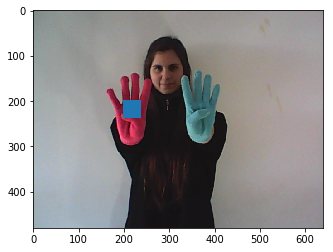

In [10]:
import matplotlib.patches as patches

def dibujar_cuadrado(position):
    size=40
    canvas = plt.gca()
    size_x,size_y=(size,size)
    position_reversed=(hand_center_position[1]-size_y/2,hand_center_position[0]-size_x/2)
    rectangle=patches.Rectangle(position_reversed, size_x,size_y, fill=True)
    canvas.add_patch(rectangle)
plt.figure()
plt.imshow(image,cmap=plt.get_cmap('gray'))

dibujar_cuadrado(hand_center_position)


### Ejercicio final: Armar una función detectora de guantes y probarla con el guante celeste


Hasta ahora logramos detectar el guante rojo. Vamos a intentar detectar el guante celeste. 

En lugar de cambiar los rangos más arriba, como ejercicio final de este tutorial, tenés que implementar una función llamada `locate_object` que reciba una imagen y los rangos de color, y devuelva la posición del objeto con ese color en la imagen. De esta forma tendremos bien organizado el código para detectar otros objetos en un futuro.

La función sólo debe hacer lo que se vió en este tutorial; convertir a hsv, filtrar por color, luego erosionar, luego calcular el centro de masa del objeto, y se puede copiar el código que vimos más arriba. 


In [11]:
def erode(segmentation_mask):
    #IMPLEMENTAR
    return 0 # retornar mascara de segmentacion erosionada

def segment_by_color(image_hsv,h_min,h_max,s_min,s_max,v_min,v_max):
    #IMPLEMENTAR
    return 0 # retornar mascara de segmentacion

def calculate_mass_center(segmentation_mask):
    #IMPLEMENTAR
    return 0 #retornar posicion

def locate_object(image_rgb,h_min,h_max,s_min,s_max,v_min,v_max):
    
    #convertir la imagen de rgb a hsv
    #IMPLEMENTAR
    
    #generar la máscara de segmentación en base al color
    #IMPLEMENTAR
    
    #erosionar la máscara
    #IMPLEMENTAR
    
    #calcular centro de masa de la máscara para encontrar la posición del objeto
    #IMPLEMENTAR
    
    return 0 # retornar posición

h_min,h_max=(0/360.0, 0/360.0)
s_min,s_max=(0/100.0, 0/100.0)
v_min,v_max=(0/100.0, 0/100.0)


blue_glove_position=locate_object(image,h_min,h_max,s_min,s_max,v_min,v_max)
print(blue_glove_position) # debería imprimir algo similar a [230.0,360.0]

0
